In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext pycodestyle_magic

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

In [30]:
%pycodestyle_on

In [55]:
a = np.array([[1, 2, 3],
            [1, 2, 3],
            [1, 2, 3],
            [1, 2, 3]])
b = np.array([4, 5, 6])
b = np.append(1, b)
b

array([1, 4, 5, 6])

2:13: E128 continuation line under-indented for visual indent


In [1]:
a = np.array([[1, 2, 3, 4, 5],
              [6, 7, 8, 9, 0]])
b = np.array([[4, 5, 6, 7, 8]])
c = np.matmul(a.T, a)
#np.matmul(c, b)

NameError: name 'np' is not defined

In [11]:
b = np.array([-1, 5, 0, 7, 8])
b

array([-1,  5,  0,  7,  8])

In [12]:
1/(1+np.exp(-b))

array([0.26894142, 0.99330715, 0.5       , 0.99908895, 0.99966465])

In [4]:
print(1)

1


In [22]:
def batch_generator(X, y, shuffle=False, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    X = np.asarray(X)
    y = np.asarray(y)
    if shuffle:
        X = np.hstack((X, y.reshape(-1, 1)))
        np.random.shuffle(X)
        y = X[:, -1]
        X = np.delete(X, -1, axis=1)
    # X_batch = ""
    # y_batch = ""
    for i in range(0, np.size(y), batch_size):
        X_batch = X[i: i + batch_size, :]
        y_batch = y[i: i + batch_size]
        yield (X_batch, y_batch)

In [41]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigma_value_x = 1/(1+np.exp(-x))
    return sigma_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10,
                 model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss = np.mean((y_batch - X_batch @ self.weights) ** 2)
            loss += 1/self.C * (self.weights ** 2)
            loss -= 1/self.C * self.weights[0] ** 2
        else:
            sigma = sigmoid(X_batch @ self.weights)
            loss = -np.mean(y_batch * np.log(sigma) + (1 - y_batch) * np.log(1 - sigma))
            loss += 1/self.C * (self.weights ** 2)
            loss -= 1/self.C * (self.weights[0] ** 2)
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss_grad = 2 * (X_batch.T @ X_batch) @ self.weights
            loss_grad -= 2 * X_batch.T @ y_batch
            loss_grad = loss_grad / np.size(y_batch)
            loss_grad += 2/self.C * self.weights
            loss_grad[0] -= 2/self.C * self.weights[0]
        else:
            a = self.predict(X_batch @ self.weights)
            loss_grad = 2/self.C * self.weights-((y_batch - a) @ X_batch)/X_batch.shape[0]
            #print(loss_grad)
            loss_grad[0] = -np.sum(y_batch - a, axis = 0)/X_batch.shape[0]
            #print(np.isclose(loss_grad[0], -np.sum(y_batch - sigma, axis = 0)/X_batch.shape[0]))
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        pass
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        X = np.asarray(X)
        self.weights = np.zeros(X.shape[1] + 1)
        X = np.hstack((np.ones(X.shape[0]).reshape(-1,1), X))
        
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                #print(batch_loss)

        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.asarray(X)
        if self.model_type == 'lin_reg':
            y_hat = np.hstack((np.ones(X.shape[0]).reshape(-1,1), X) @ self.weights)
        else:
            y_hat = sigmoid(X) @ self.weights
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

In [32]:
def plot_decision_boundary(clf):
    x = [0, 5]
    if clf.model_type == 'log_reg':
        plt.plot(x, [(-clf.weights[0]) /clf.weights[2] - clf.weights[1]/clf.weights[2] * x[0], 
                 -clf.weights[0]/clf.weights[2] - clf.weights[1]/clf.weights[2] * x[1]])
    else:
        plt.plot(x, [(-clf.weights[0] + 0.5) /clf.weights[2] - clf.weights[1]/clf.weights[2] * x[0], 
            (-clf.weights[0] + 0.5)/clf.weights[2] - clf.weights[1]/clf.weights[2] * x[1]])
    pass

In [33]:
from sklearn.linear_model import LogisticRegression

[-5.95169714] [ 1.18906085 -1.448645  ]
-1.1352367624941795 -0.132151967878572 0.1024801851199111


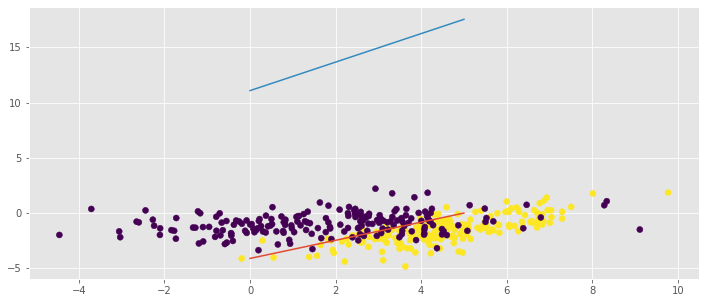

In [40]:
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)


X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
scclf = LogisticRegression()
scclf.fit(X, y)
   
log_clf = MySGDClassifier(batch_generator,model_type = 'log_reg')
log_clf.fit(X, y)
lin_clf = MySGDClassifier(batch_generator,model_type = 'lin_reg')
lin_clf.fit(X, y)
#print(scclf.coef_)
x = [0, 5]
inter = scclf.intercept_
coef = scclf.coef_.reshape(-1)
print(inter, coef)
plt.plot(x, [(-inter) /coef[1] - coef[0]/coef[1] * x[0], 
          -inter/coef[1] - coef[0]/coef[1] * x[1]])
print(log_clf.weights[0], log_clf.weights[1], log_clf.weights[2])
#print(clf.errors_log)
#plot_decision_boundary(lin_clf)
plot_decision_boundary(log_clf)

plt.scatter(X[:,0], X[:,1], c=y)